In [28]:
import torch
import scanpy as sc

from sklearn.metrics import adjusted_rand_score, silhouette_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.decomposition import PCA
from scvi.model import SCVI
from scripts import constants
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

from anndata import AnnData

In [2]:
dataset = "cain_2020_excluding_cog_only"
adata = sc.read_h5ad(
    os.path.join(
        constants.DEFAULT_DATA_PATH,
        f"{dataset}/preprocessed/adata_top_2000_genes_tc.h5ad",
    )
)

In [3]:
seeds = [123, 42, 789, 46, 999]
latent_size = 10

In [4]:
dataset_split_lookup = constants.DATASET_SPLIT_LOOKUP
split_key = dataset_split_lookup[dataset]["split_key"]
background_value = dataset_split_lookup[dataset]["background_value"]
target_adata = adata[adata.obs[split_key] != background_value]

In [5]:
latent_rep_list = [
    np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/contrastiveVI/latent_{latent_size}/{seed}/latent_representations.npy",
        ),
    )
    for seed in tqdm(seeds)
]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 240.99it/s]


In [6]:
latent_rep_adata_list = []
for latent_rep in latent_rep_list:
    latent_rep_adata = AnnData(
        X=latent_rep,
        obs=target_adata.obs,
        var=pd.DataFrame(index=[f"latent_{i}" for i in range(latent_size)]),
    )
    latent_rep_adata.obs["diagnosis"] = np.where(
        latent_rep_adata.obs["combined_diagnosis"] == "Both",
        "Pathological and cognitive",
        "Pathological only",
    )
    latent_rep_adata_list.append(latent_rep_adata)

### UMAP plots

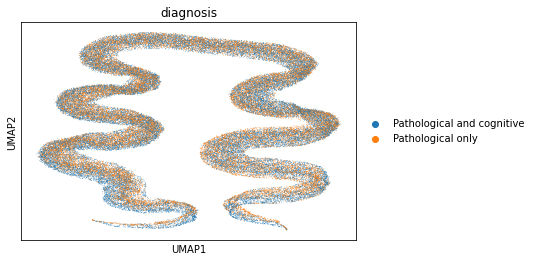

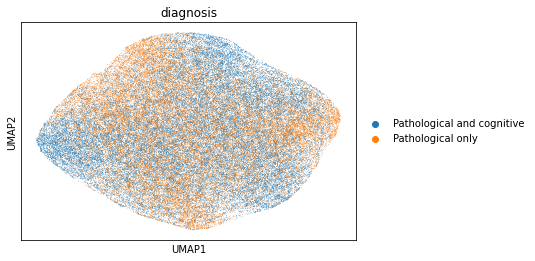

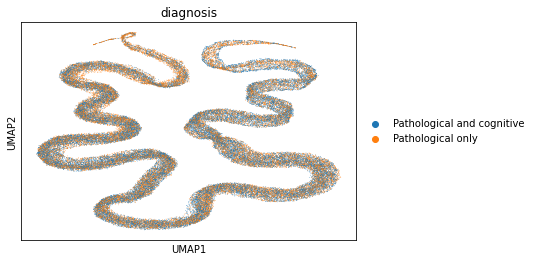

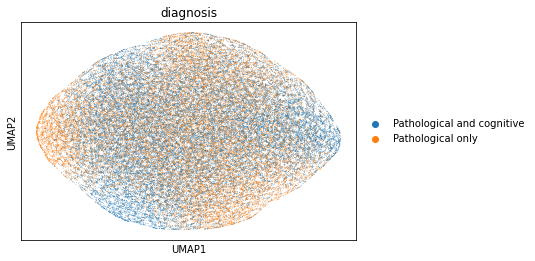

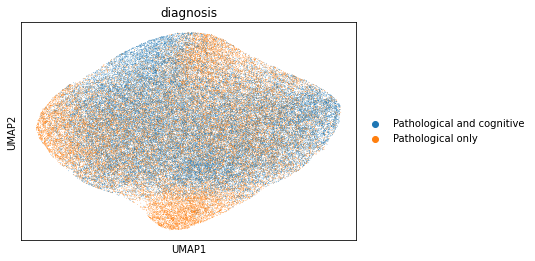

In [7]:
for latent_rep_adata in latent_rep_adata_list:
    sc.pp.neighbors(latent_rep_adata)
    sc.tl.umap(latent_rep_adata)
    sc.pl.umap(latent_rep_adata, color="diagnosis")

### PC plots

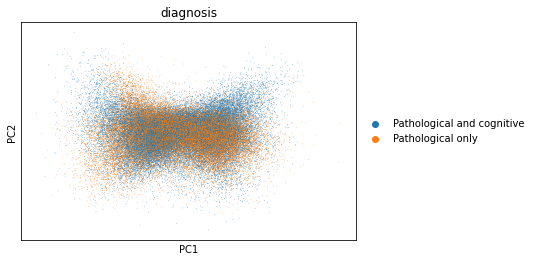

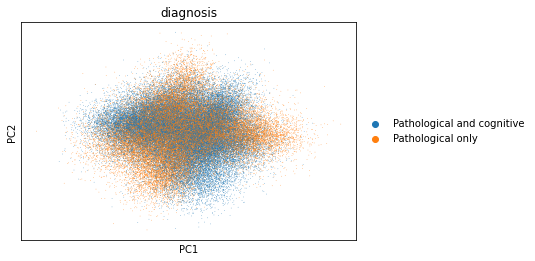

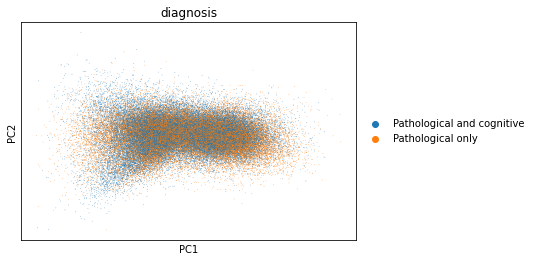

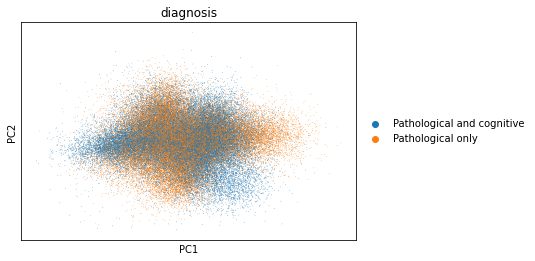

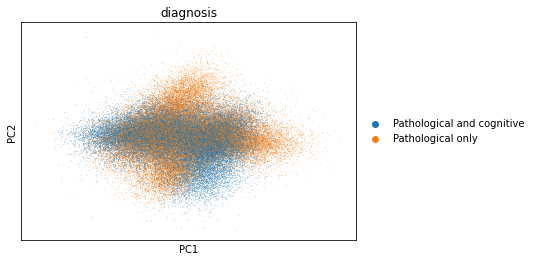

In [8]:
for latent_rep_adata in latent_rep_adata_list:
    sc.tl.pca(latent_rep_adata)
    sc.pl.pca(latent_rep_adata, color="diagnosis")

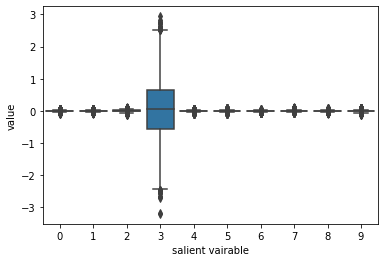

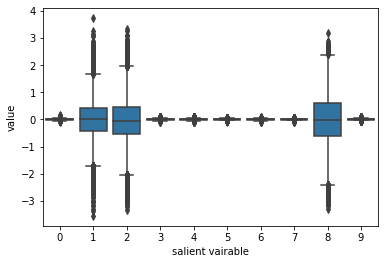

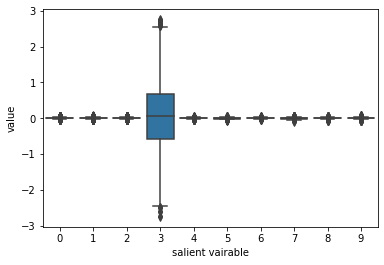

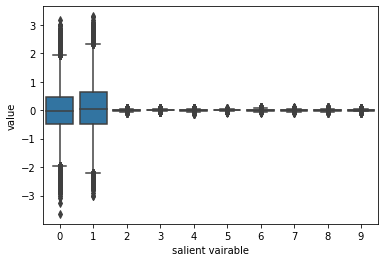

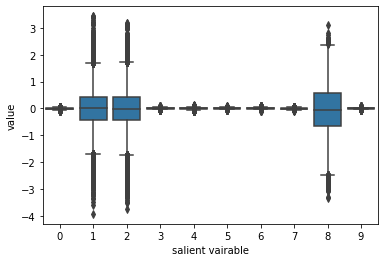

In [42]:
for latent_rep_adata in latent_rep_adata_list:
    df = pd.DataFrame(latent_rep_adata.X)
    df.columns = [f"{i}" for i in df.columns]
    df = pd.melt(df)
    df = df.rename(columns={"variable": "salient vairable"})
    plt.figure()
    g = sns.boxplot(x="salient vairable", y="value", data=df, color="tab:blue")